In [4]:
%load_ext autoreload
%autoreload 2

from ntiles import Ntile

from portal import PricingPortal
from toolbox.constitutes.constitute_adjustment import ConstituteAdjustment
from toolbox.db.read.query_constructor import QueryConstructor


In [5]:
tbl = 'crsp.security_daily'
uni = 'CRSP_US_1000_3000'
start = '2010'
end = '2020'
search_by = 'permno'

In [6]:
ca = ConstituteAdjustment(search_by, 'period')
ca.add_index_info_from_db(uni, start, end)

In [7]:
pricing_portal = PricingPortal(uni, schema='crsp', search_by=search_by, start=start, end=end, field='prc')
tile = Ntile(pricing_portal)

NumExpr defaulting to 8 threads. ::: 04:07:36 PM


In [8]:
factor_tmp = QueryConstructor().\
    query_timeseries_table(tbl, assets=uni, search_by=search_by, start_date=str(int(start)-1), end_date=end,
                           fields=['prc', 'siccd', 'shrout']).distinct().set_calendar('NYSE').shift(20, 'prc')\
    .shift(250, 'prc').add_to_select("prc * shrout * -1 as market_cap").df

In [9]:
factor = factor_tmp.unstack().shift(1).stack()
factor['siccd'] = factor['siccd'].str[:2]
factor['price_mo'] = factor.prc_lag_20 / factor.prc_lag_250 - 1
factor['price_rev'] = (factor.prc / factor.prc_lag_20 - 1) * -1

del factor['prc_lag_20'], factor['prc_lag_250'], factor['shrout'], factor['prc']

In [10]:
alpha = ca.adjust_data_for_membership(factor, 'factor').reset_index().set_index(['date', search_by, 'siccd'])

groups = ['date', 'siccd']
alpha = alpha.groupby(groups).rank(pct=True)
alpha['combo'] = alpha[['price_mo', 'price_rev', 'market_cap']].sum(axis=1)
alpha['mo_rev'] = alpha[['price_mo', 'price_rev']].sum(axis=1)
alpha['mo_rev'] = alpha.groupby(groups).mo_rev.rank(pct=True)
alpha = alpha[alpha.index.get_level_values(0) > '2011']  #.dropna()

alpha = alpha.reset_index().set_index(['date', search_by])

Unable to map 0.0% of factor values to returns
Quantiles Statistics


,Median,Std,Min,Max,Count,Count %
Ntile:,,,,,,
1,0.92,0.06,0.81,1.00,877820,19.94
2,0.72,0.06,0.61,0.82,882338,20.04
3,0.52,0.06,0.41,0.62,878466,19.95
4,0.32,0.06,0.21,0.42,882057,20.03
5,0.12,0.06,0.00,0.22,882254,20.04


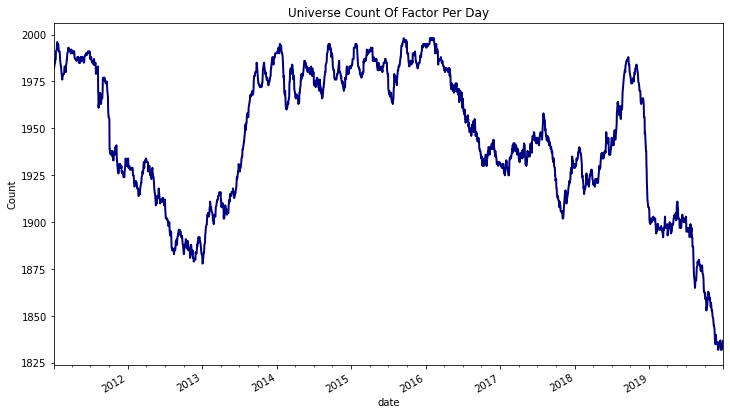

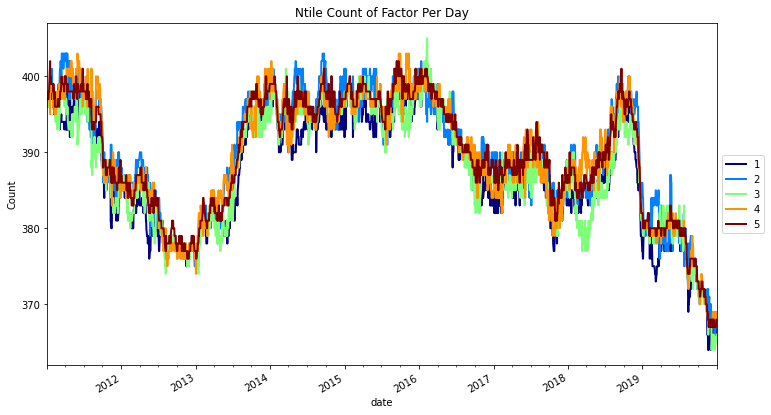

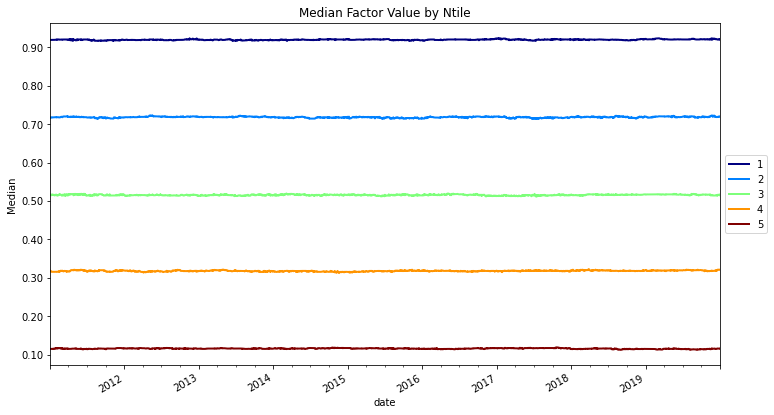

Ntile Backtest


,Sharpe,CAGR,Annual Vol,Max Drawdown,% Periods Up
Ntile: 1,0.65,2.57,4.00,-6.96,0.51
Ntile: 2,1.13,2.01,1.78,-2.26,0.52
Ntile: 3,0.33,0.53,1.62,nan,0.50
Ntile: 4,-0.83,-1.66,1.99,-4.72,0.48
Ntile: 5,-1.10,-3.49,3.18,-4.25,0.50


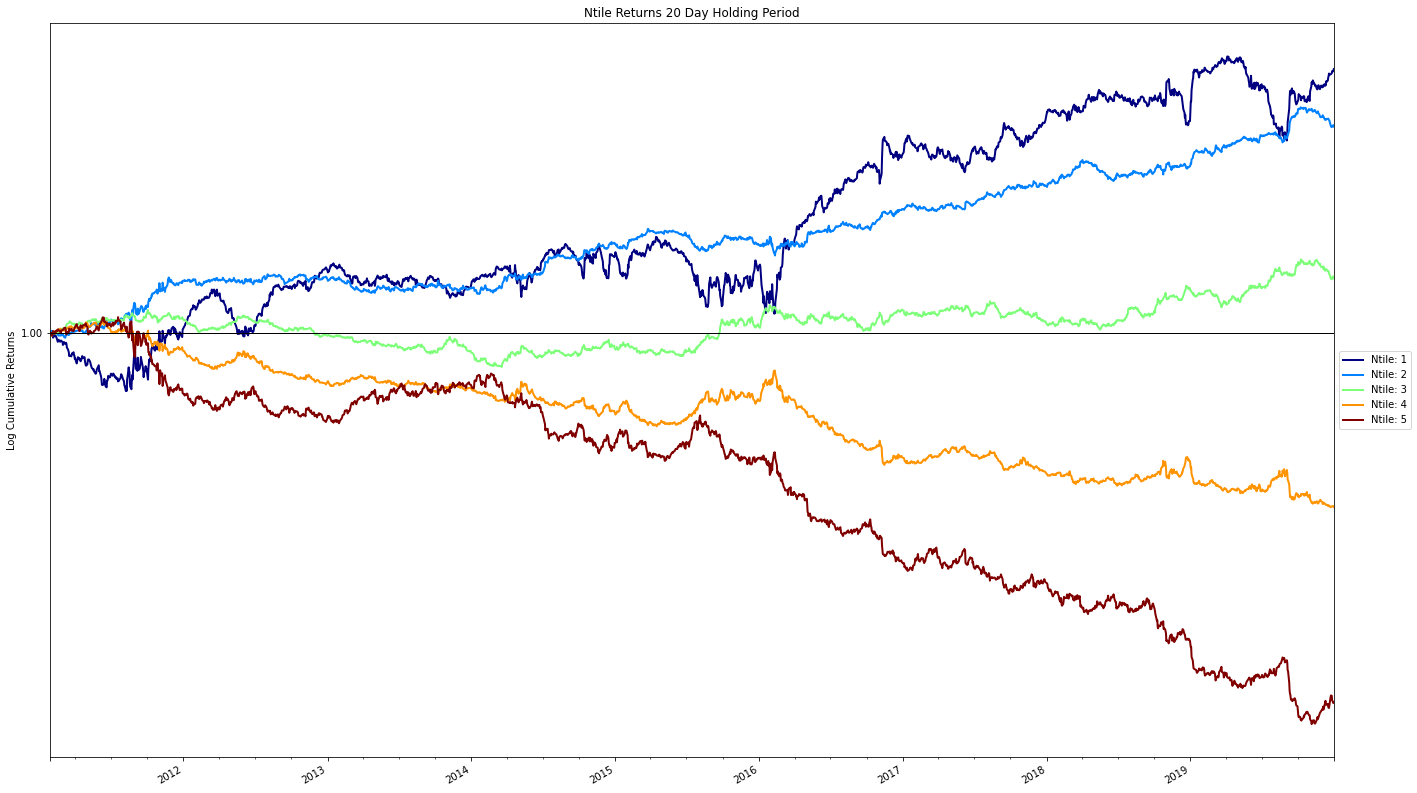

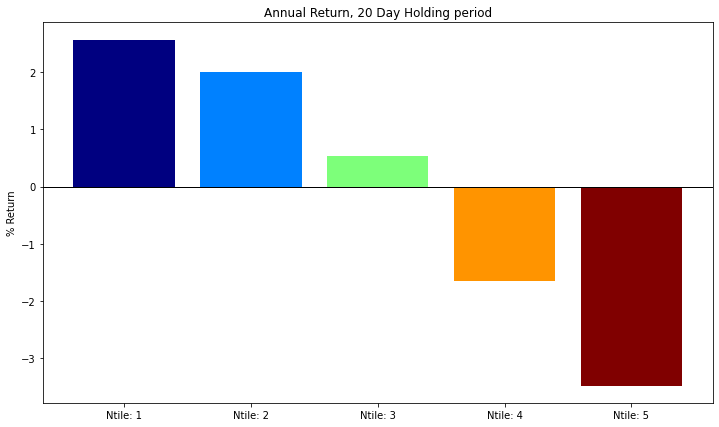

,Sharpe,CAGR,Annual Vol,Max Drawdown,% Periods Up
universe,0.68,10.41,16.71,-26.82,0.54
1 vs 5,0.95,3.05,3.21,-4.65,0.50
2 vs 4,1.10,1.83,1.65,-3.44,0.52


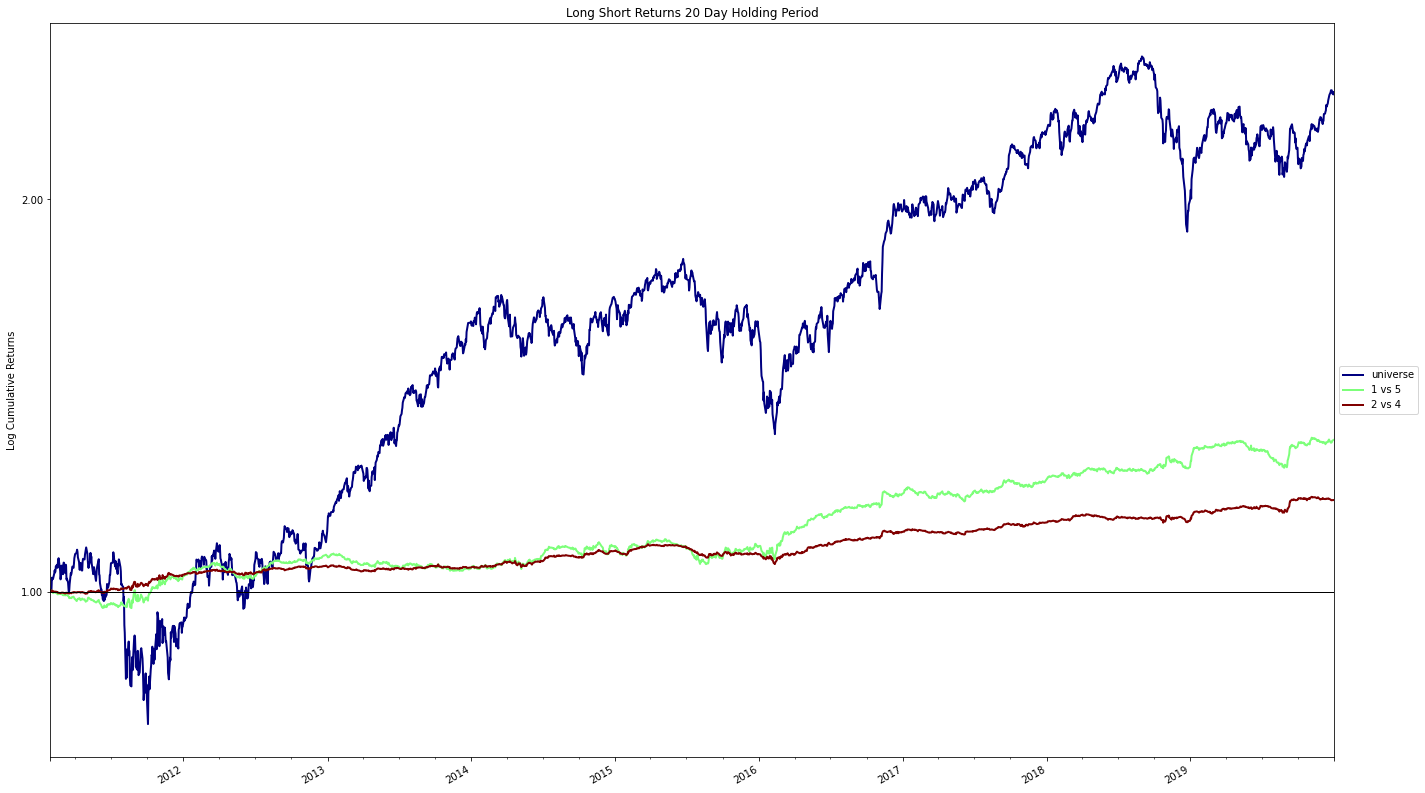

Information Coefficient


,IC Mean,IC Median,IC Std,Risk Adjusted IC,IC Skew
20D,0.009,0.006,0.061,0.142,0.514


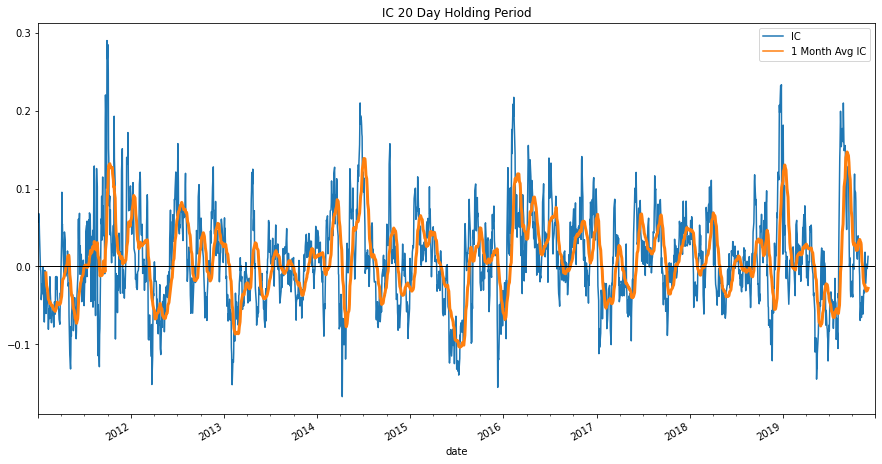

Turnover


,Mean AC,Median AC,Std AC
20D,-0.018,-0.013,0.072


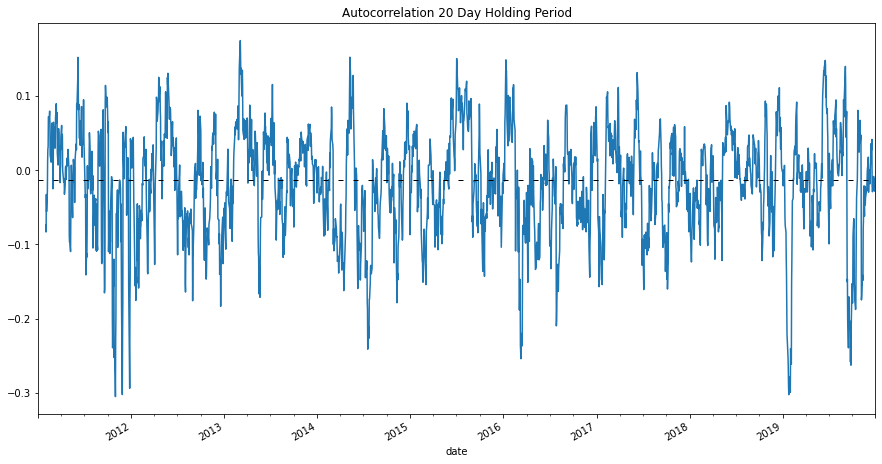

In [11]:

t = tile.full_tear(alpha.price_rev, holding_period=20, ntiles=5, show_uni=True, market_neutral=True)
del t